In [66]:
import os
import yaml
import json
from argparse import ArgumentParser
import pdb
import numpy as np
import networkx as nx
from data.dataset_real_eye_vessels import build_real_vessel_network_data
import torch
from monai.data import DataLoader
from tqdm import tqdm
import numpy as np

from data.dataset_road_network import build_road_network_data
from data.dataset_synthetic_eye_vessels import build_synthetic_vessel_network_data
from models import build_model
from training.inference import relation_infer
from metrics.metric_smd import StreetMoverDistance
from metrics.metric_map import BBoxEvaluator
from utils.box_ops_2D import box_cxcywh_to_xyxy_np
from utils.utils import image_graph_collate_road_network
from metrics.topo import compute_topo
from test import dict2obj, ensure_format
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

from torch_geometric.utils import to_networkx
from tqdm import tqdm

from data.visualize_sample import draw_graph
from torch_geometric.data import Dataset, Data
from data.distances.gmd import _compute_gmd
from multiprocessing import Pool, cpu_count

In [67]:
config = './trained_weights/runs/octa_3000v2_10/config.yaml'

In [68]:
checkpoint = './trained_weights/runs/octa_3000v2_10/models/checkpoint_epoch=100.pt'

In [69]:
num_test_samples = 200

In [70]:
with open(config) as f:
    print('\n*** Config file')
    print(config)
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config['log']['message'])
config = dict2obj(config)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


*** Config file
./trained_weights/runs/octa_3000v2_10/config.yaml
exp


In [71]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.multiprocessing.set_sharing_strategy('file_system')
device = torch.device("cuda")

config.DATA.MIXED = False

net = build_model(config).to(device)

config.DATA.MIXED = False

if config.DATA.DATASET == 'road_dataset' or config.DATA.DATASET == 'mixed_road_dataset':
    build_dataset_function = build_road_network_data
elif config.DATA.DATASET == 'synthetic_eye_vessel_dataset' or config.DATA.DATASET == 'mixed_synthetic_eye_vessel_dataset':
    build_dataset_function = build_synthetic_vessel_network_data
elif config.DATA.DATASET == 'real_eye_vessel_dataset' or config.DATA.DATASET == 'mixed_real_eye_vessel_dataset':
    build_dataset_function = build_real_vessel_network_data

test_ds = build_dataset_function(
    config, mode='test', max_samples=num_test_samples, use_grayscale=False
)

In [72]:
batch_size = 1
test_loader = DataLoader(test_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=config.DATA.NUM_WORKERS,
                        collate_fn=image_graph_collate_road_network,
                        pin_memory=True)

# load checkpoint
checkpoint = torch.load(checkpoint, map_location=device)
net.load_state_dict(checkpoint['net'], strict=True)
_ = net.eval()

In [73]:
results = []

metric_smd = StreetMoverDistance(eps=1e-5, max_iter=10, reduction='none')

metric_node_map = BBoxEvaluator(['node'], max_detections=100)
metric_edge_map = BBoxEvaluator(['edge'], max_detections=100)

    
with torch.no_grad():
    for i, batchdata in enumerate(tqdm(test_loader)):

        # extract data and put to device
        images, segs, nodes, edges = batchdata[0], batchdata[1], batchdata[2], batchdata[3]
        images = images.to(device,  non_blocking=False)
        segs = segs.to(device,  non_blocking=False)
        nodes = [node.to(device,  non_blocking=False) for node in nodes]
        edges = [edge.to(device,  non_blocking=False) for edge in edges]

        h, out, _, _, _, _ = net(images, seg=False)
        pred_nodes, pred_edges, pred_nodes_box, pred_nodes_box_score, pred_nodes_box_class, pred_edges_box_score, pred_edges_box_class = relation_infer(
            h.detach(), out, net, config.MODEL.DECODER.OBJ_TOKEN, config.MODEL.DECODER.RLN_TOKEN,
            nms=False, map_=True
        )
        
        ret = metric_smd(nodes, edges, pred_nodes, pred_edges)

        # Add elements of current batch elem to node map evaluator
        metric_node_map.add(
            pred_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1)) for nodes_ in pred_nodes],
            pred_classes=pred_nodes_box_class,
            pred_scores=pred_nodes_box_score,
            gt_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1)) for nodes_ in nodes],
            gt_classes=[np.ones((nodes_.shape[0],)) for nodes_ in nodes]
        )

        beta_error = 0
        # Calculate betti scores
        for nodes_sample, edges_sample, pred_nodes_sample, pred_edges_sample in zip(nodes, edges, pred_nodes, pred_edges):
            G1 = nx.Graph()
            G1.add_nodes_from([i for i, n in enumerate(nodes_sample)])
            G1.add_edges_from([tuple(e) for e in edges_sample.cpu().tolist()])
            connected_components = len(list(nx.connected_components(G1)))
            beta_gt = np.array([connected_components, len(G1.edges) + connected_components - len(G1.nodes)])

            G2 = nx.Graph()
            G2.add_nodes_from([i for i, n in enumerate(pred_nodes_sample)])
            G2.add_edges_from([tuple(e) for e in pred_edges_sample])
            connected_components = len(list(nx.connected_components(G2)))
            beta_pred = np.array([connected_components, len(G2.edges) + connected_components - len(G2.nodes)])
            beta_error = 2 * np.abs(beta_pred - beta_gt) / (beta_gt + beta_pred + 1e-10)

        # Add elements of current batch elem to edge map evaluator
        pred_edges_box = []
        for edges_, nodes_ in zip(pred_edges, pred_nodes):
            nodes_ = nodes_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_[edges_[:, 0]], nodes_[edges_[:, 1]]]))
            pred_edges_box.append(edges_box)

        gt_edges_box = []
        for edges_, nodes_ in zip(edges, nodes):
            nodes_ , edges_ = nodes_.cpu().numpy(), edges_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_[edges_[:, 0]], nodes_[edges_[:, 1]]]))
            gt_edges_box.append(edges_box)

        metric_edge_map.add(
            pred_boxes=pred_edges_box,
            pred_classes=pred_edges_box_class,
            pred_scores=pred_edges_box_score,
            gt_boxes=gt_edges_box,
            gt_classes=[np.ones((edges_.shape[0],)) for edges_ in edges]
        )

        topo = 0
        for node_, edge_, pred_node_, pred_edge_ in zip(nodes, edges, pred_nodes, pred_edges):
            topo = compute_topo(node_.cpu(), edge_.cpu(), pred_node_, pred_edge_)

        nodes = torch.squeeze(torch.stack(nodes))
        edges = torch.squeeze(torch.stack(edges))
        nodes_ones = torch.ones(nodes.size(0)).view(-1, 1)
        graph = Data(
                x=nodes_ones,
                edge_index=edges.t(),
                pos=nodes,
            )
        
        pred_nodes = torch.squeeze(torch.stack(pred_nodes))
        pred_edges = torch.squeeze(torch.tensor(pred_edges))
        pred_nodes_ones = torch.ones(pred_nodes.size(0)).view(-1, 1)
        if  pred_edges.size(0) == 0:
            pred_edges = torch.empty(0, 2)

        pred_graph = Data(
                x=pred_nodes_ones,
                edge_index=pred_edges.t(),
                pos=pred_nodes,
            )
    
    
        node_metric_scores = metric_node_map.eval()
        edge_metric_scores = metric_edge_map.eval()
        metric_node_map.reset()
        metric_edge_map.reset()
                
        results.append({'pair': [graph.cpu(), pred_graph.cpu()], 
                       'node_mAP': node_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100'][0],
                        'node_mAR': node_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100'][0],
                       'edge_mAP': edge_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100'][0],
                        'edge_mAR': edge_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100'][0],
                       'beta_error_0': beta_error[0], 
                        'beta_error_1': beta_error[1], 
                       'topo_p': topo[0],
                       'topo_r': topo[1], 
                       'smd': ret[0].cpu()})

100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


In [74]:
def plot_components(g, ax):
    g_nx = to_networkx(g).to_undirected()
    connected_components = list(nx.connected_components(g_nx))

    for component_nodes in connected_components:

        subgraph = g_nx.subgraph(component_nodes)
        component_nodes_srt = sorted(list(component_nodes))

        translated_edges = [(component_nodes_srt.index(e_1), component_nodes_srt.index(e_2)) for e_1, e_2 in subgraph.edges]
        translated_pos = g.pos[component_nodes_srt]

        draw_graph(translated_pos, translated_edges, ax)

In [75]:
def plot_with_conn_comp(results):
    rows = len(results)
    
    fig = plt.figure()
    fig.set_size_inches(8, 4 * rows)

    subfigs = fig.subfigures(rows, 1)

    for i, res in enumerate(tqdm(results)):
        g1 = res['pair'][0]
        g2 = res['pair'][1]

        ax1, ax2 = subfigs[i].subplots(1, 2)
        
        plot_components(g1, ax1)
        plot_components(g2, ax2)
        
        title = '\n'.join([f"{k}: {res[k]:.2f}" for k in sorted(res.keys() - {"pair", "gmd", "ged"})])
        
#         title += f'\n ged: {res["ged"]} \n gmd: {res["gmd"]}'
        
        title += f'\n\n gmd_e10: {res["gmd_e10"]} \n gmd_v10: {res["gmd_v10"]}'

        subfigs[i].text(1, 0.3, title, fontsize=12)
#         subfigs[i].suptitle(title, fontsize=12)

In [76]:
def add_graph_metrics(res):
    g1 = res['pair'][0]
    g2 = res['pair'][1]

    if g1.edge_index.ndim == 1:
        g1.edge_index = torch.empty(2, 0)
    if g2.edge_index.ndim == 1:
        g2.edge_index = torch.empty(2, 0)

#         ged = nx.graph_edit_distance(to_networkx(g1).to_undirected(), to_networkx(g2).to_undirected(), timeout=10)
#         res['ged'] = ged

    C_V = 1
    C_E = 10
    M = 1
    gmd = _compute_gmd([[g1, g2], C_V, C_E, M])

    res['gmd_e10'] = gmd['gmd']

    C_V = 10
    C_E = 1
    M = 1
    gmd = _compute_gmd([[g1, g2], C_V, C_E, M])

#         res['ged'] = ged
    res['gmd_v10'] = gmd['gmd']
    return res


In [77]:
results_with_metrics = []
with Pool(processes=cpu_count()) as pool:
    results_with_metrics = pool.map(add_graph_metrics, results[:100], chunksize=1)

In [78]:
def sort(results, key, reverse=False):
    return sorted(results, key=lambda x: x[key], reverse=reverse)

100%|██████████| 20/20 [00:00<00:00, 29.64it/s]


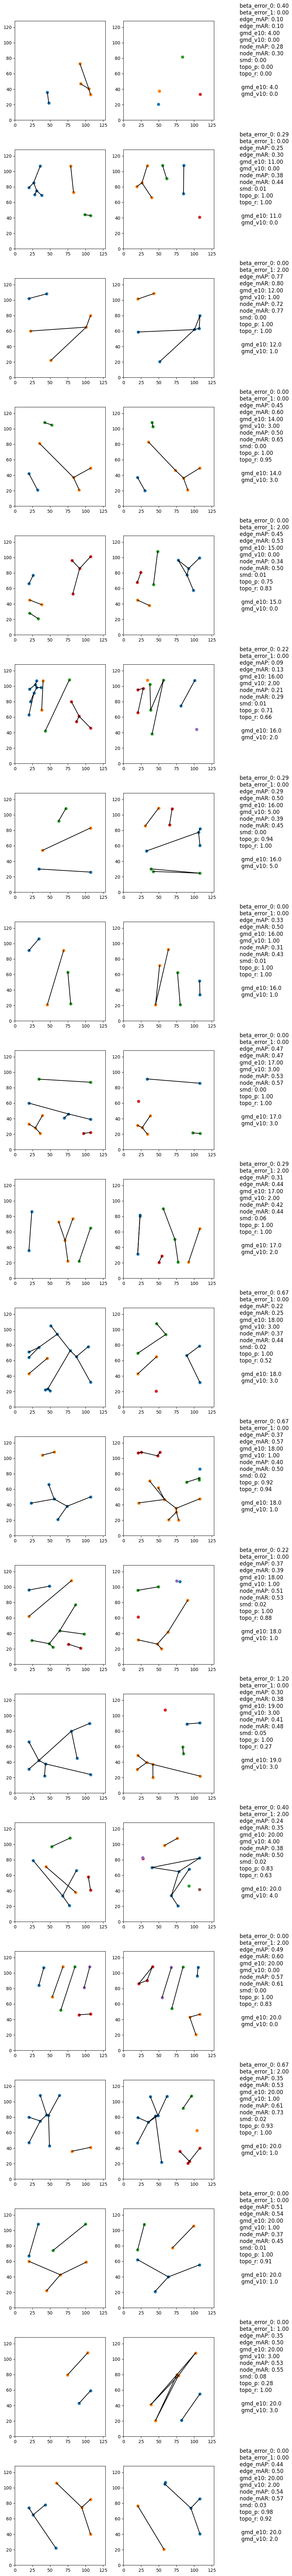

In [79]:
plot_with_conn_comp(sort(results_with_metrics, 'gmd_e10')[:20])

100%|██████████| 20/20 [00:01<00:00, 12.13it/s]


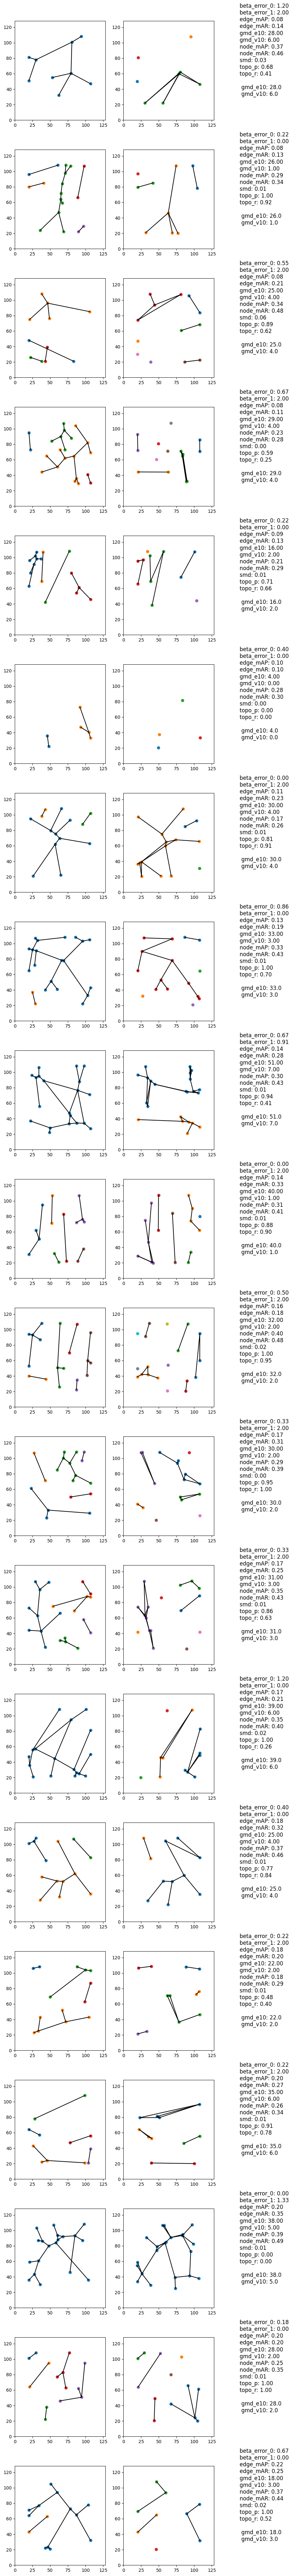

In [81]:
plot_with_conn_comp(sort(results_with_metrics, 'edge_mAP')[:20])